# Covid -19 Interrupted Time Series Analysis

The purpose of this notebook is to analyze the effect of masking policies and the compliance of these policies amomg the population at Franklin in Ohio in United States during COVID-19 for the time spaen between February 1, 2020 through October 1, 2021. The data sets used for this analysis are curated from the below mentioned links.
1. [John Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university)
2. [masking mandates by county](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i)
3. [mask compliance survey](https://github.com/nytimes/covid-19-data/tree/master/mask-use)

# Import the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import warnings
warnings.simplefilter("ignore", UserWarning)
from statsmodels.tsa.arima.model import ARIMA

## Step 1 :Data Acquisition - collecting data from the above mentioned links

In [2]:
raw_csv_data = pd.read_csv("../data/RAW_us_confirmed_cases.csv")
df_comp_snohomish = raw_csv_data[raw_csv_data['Admin2'] == 'Snohomish']

raw_csv_public_mask_mandate = pd.read_csv("../data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
df_mask_snohomish = raw_csv_public_mask_mandate[raw_csv_public_mask_mandate['County_Name'] == 'Snohomish County']


In [3]:
df_comp_snohomish.columns

Index(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS',
       'Country_Region', 'Lat', 'Long_',
       ...
       '10/21/22', '10/22/22', '10/23/22', '10/24/22', '10/25/22', '10/26/22',
       '10/27/22', '10/28/22', '10/29/22', '10/30/22'],
      dtype='object', length=1024)


# Simplifying the dataset

In [4]:
df_comp = df_comp_snohomish.drop(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)
df_comp.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
3176,0,0,0,0,0,0,0,0,0,0,...,193751,193751,193751,193911,193911,194059,194059,194059,194059,194059


In [5]:
df_snohomish = df_comp.melt(id_vars=[], 
        var_name="date", 
        value_name="infections")

In [6]:
df_snohomish.head()

,date,infections
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0


In [7]:
df_snohomish.describe()

,infections
count,1013.000000
mean,67177.082922
std,67132.254762
min,0.000000
25%,7201.000000
50%,39459.000000
75%,146313.000000
max,194059.000000


In [8]:
df_snohomish.infections.isna().sum()

0

In [9]:
# Convert date column which is text to proper date format. 
# df_snohomish['date'] = pd.to_datetime(df_snohomish['date'], dayfirst=True)
#df_snohomish.set_index("date", inplace=True)
df_snohomish.head()

,date,infections
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0


In [10]:
df_mask_snohomish.columns

Index(['State_Tribe_Territory', 'County_Name', 'FIPS_State', 'FIPS_County',
       'date', 'order_code', 'Face_Masks_Required_in_Public',
       'Source_of_Action', 'URL', 'Citation'],
      dtype='object')

In [11]:
df_comp_mask = df_mask_snohomish.drop(['State_Tribe_Territory', 'County_Name', 'FIPS_State', 'FIPS_County', 'order_code', 'Source_of_Action', 'URL', 'Citation'], axis=1)

In [12]:
df_comp_mask

,date,Face_Masks_Required_in_Public
793309,6/6/2020,NaN
793446,6/7/2020,NaN
793480,4/10/2020,NaN
793481,4/11/2020,NaN
793482,4/12/2020,NaN
...,...,...
1537447,8/11/2021,Yes
1537448,8/12/2021,Yes
1537449,8/13/2021,Yes
1537450,8/14/2021,Yes


In [13]:
df_comp_mask.Face_Masks_Required_in_Public.value_counts()

Yes    416
Name: Face_Masks_Required_in_Public, dtype: int64

In [14]:
df_comp_mask.Face_Masks_Required_in_Public.fillna("No", inplace = True)
df_comp_mask.Face_Masks_Required_in_Public.value_counts()

Yes    416
No      77
Name: Face_Masks_Required_in_Public, dtype: int64

In [15]:
df_snohomish['date'] = pd.to_datetime(df_snohomish['date'])
df_comp_mask['date'] = pd.to_datetime(df_comp_mask['date'])

In [16]:

df_combined = pd.merge_ordered(df_snohomish, df_comp_mask, how='left', on="date")

In [17]:
df_combined

,date,infections,Face_Masks_Required_in_Public
0,2020-01-22,0,NaN
1,2020-01-23,0,NaN
2,2020-01-24,0,NaN
3,2020-01-25,0,NaN
4,2020-01-26,0,NaN
...,...,...,...
1008,2022-10-26,194059,NaN
1009,2022-10-27,194059,NaN
1010,2022-10-28,194059,NaN
1011,2022-10-29,194059,NaN


In [18]:
df_combined.Face_Masks_Required_in_Public.value_counts()

Yes    416
No      77
Name: Face_Masks_Required_in_Public, dtype: int64

In [19]:
df_combined.Face_Masks_Required_in_Public.isna().sum()

520

In [20]:
# start_date = '2020-02-01'
# end_date   = '2021-10-01'

# mask = (df_combined['date'] > start_date) & (df_combined['date'] <= end_date)
# df_combined = df_combined.loc[mask]


In [21]:
df_combined.Face_Masks_Required_in_Public.value_counts()

Yes    416
No      77
Name: Face_Masks_Required_in_Public, dtype: int64

In [22]:
df_combined.Face_Masks_Required_in_Public = df_combined.Face_Masks_Required_in_Public.fillna(method = 'bfill')

In [23]:
df_combined.Face_Masks_Required_in_Public = df_combined.Face_Masks_Required_in_Public.fillna(method = 'ffill')

In [24]:
df_combined.Face_Masks_Required_in_Public.value_counts()

Yes    857
No     156
Name: Face_Masks_Required_in_Public, dtype: int64

In [25]:
df_combined['test_date'] = df_combined['date'] - timedelta(days=3)

In [26]:
df_combined['Face_Masks_Required_in_Public'] = df_combined['Face_Masks_Required_in_Public'].map({'Yes':1, 'No':0})

In [27]:
df_combined['policy_day'] = df_combined['Face_Masks_Required_in_Public'].cumsum()

In [28]:
df_combined['days'] = np.arange(1,len(df_combined)+1)
df_combined

,date,infections,Face_Masks_Required_in_Public,test_date,policy_day,days
0,2020-01-22,0,0,2020-01-19,0,1
1,2020-01-23,0,0,2020-01-20,0,2
2,2020-01-24,0,0,2020-01-21,0,3
3,2020-01-25,0,0,2020-01-22,0,4
4,2020-01-26,0,0,2020-01-23,0,5
...,...,...,...,...,...,...
1008,2022-10-26,194059,1,2022-10-23,853,1009
1009,2022-10-27,194059,1,2022-10-24,854,1010
1010,2022-10-28,194059,1,2022-10-25,855,1011
1011,2022-10-29,194059,1,2022-10-26,856,1012


In [29]:
df_combined.infections = df_combined.infections.replace({'0':np.nan, 0:np.nan})

In [30]:
df_combined.infections = df_combined.infections.fillna(method = 'bfill')

In [31]:
df_combined

,date,infections,Face_Masks_Required_in_Public,test_date,policy_day,days
0,2020-01-22,1.0,0,2020-01-19,0,1
1,2020-01-23,1.0,0,2020-01-20,0,2
2,2020-01-24,1.0,0,2020-01-21,0,3
3,2020-01-25,1.0,0,2020-01-22,0,4
4,2020-01-26,1.0,0,2020-01-23,0,5
...,...,...,...,...,...,...
1008,2022-10-26,194059.0,1,2022-10-23,853,1009
1009,2022-10-27,194059.0,1,2022-10-24,854,1010
1010,2022-10-28,194059.0,1,2022-10-25,855,1011
1011,2022-10-29,194059.0,1,2022-10-26,856,1012


In [32]:
df_combined = df_combined.drop(['date', 'test_date'], axis=1)

In [33]:
df_combined['infections'] = np.log2(df_combined['infections'])

In [34]:
df_combined


,infections,Face_Masks_Required_in_Public,policy_day,days
0,0.000000,0,0,1
1,0.000000,0,0,2
2,0.000000,0,0,3
3,0.000000,0,0,4
4,0.000000,0,0,5
...,...,...,...,...
1008,17.566136,1,853,1009
1009,17.566136,1,854,1010
1010,17.566136,1,855,1011
1011,17.566136,1,856,1012


# Naive Solution

In [35]:
model = smf.ols(formula='infections ~ Face_Masks_Required_in_Public + policy_day + days', data=df_combined)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             infections   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     5035.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:08:13   Log-Likelihood:                -1375.6
No. Observations:                1013   AIC:                             2759.
Df Residuals:                    1009   BIC:                             2779.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

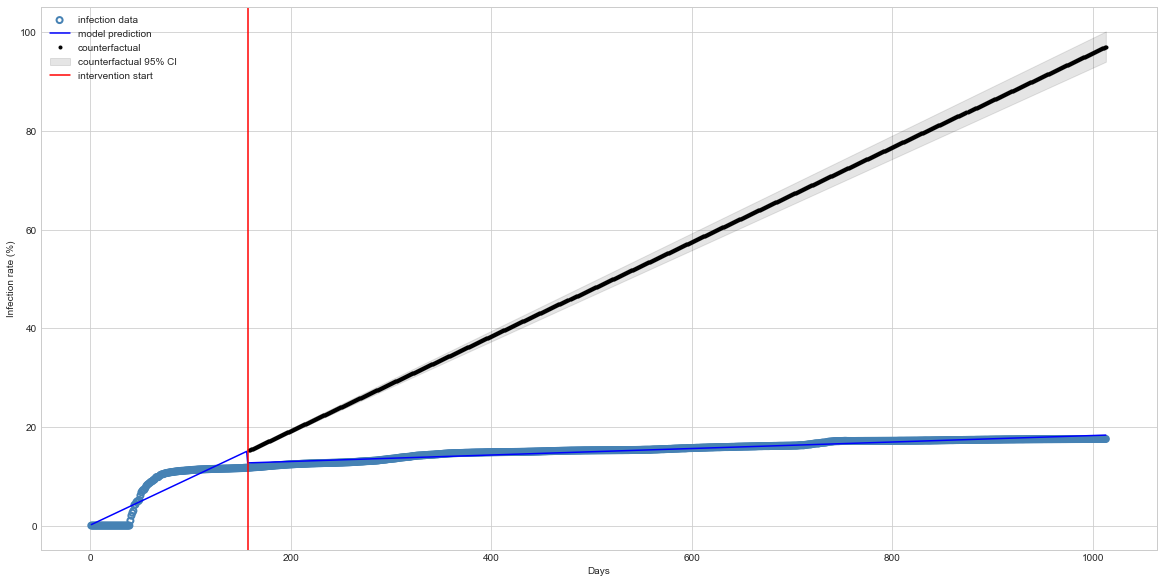

In [36]:
start = 157
end = 463
beta = res.params

# Get model predictions and 95% confidence interval
predictions = res.get_prediction(df_combined)
summary = predictions.summary_frame(alpha=0.05)

# mean predictions
y_pred = predictions.predicted_mean

# countefactual assumes no interventions
cf_df = df_combined.copy()
cf_df["Face_Masks_Required_in_Public"] = 0.0
cf_df["policy_day"] = 0.0

# counter-factual predictions
cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

# Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(20,10))

# Plot infections data
ax.scatter(df_combined["days"], df_combined["infections"], facecolors='none', edgecolors='steelblue', label="infection data", linewidths=2)

# Plot model mean infection prediction
ax.plot(df_combined["days"][:start], y_pred[:start], 'b-', label="model prediction")
ax.plot(df_combined["days"][start:], y_pred[start:], 'b-')

# Plot counterfactual mean infection rate with 95% confidence interval
ax.plot(df_combined["days"][start:], cf['mean'][start:], 'k.', label="counterfactual")
ax.fill_between(df_combined["days"][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='k', alpha=0.1, label="counterfactual 95% CI");

# Plot line marking intervention moment
ax.axvline(x = 157, color = 'r', label = 'intervention start')

ax.legend(loc='best')
plt.xlabel("Days")
plt.ylabel("Infection rate (%)");

# Plotting the distribution of residuals:

<AxesSubplot:ylabel='Density'>

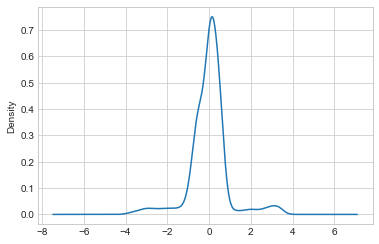

In [37]:
 res.resid.plot(kind="kde")

# Autoregressive model solution
- The autoregressive model specifies that each observation depends linearly on previous observations.

#### To assess how much an observation correlates with past observations it is useful to do an autocorrelation plot as shown below:

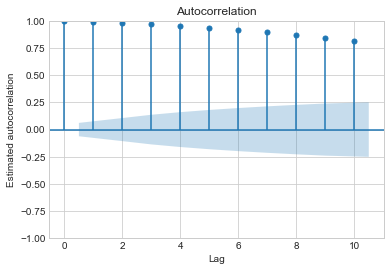

In [38]:
sm.graphics.tsa.plot_acf(res.resid, lags=10)
plt.xlabel("Lag",fontsize = 10)
plt.ylabel("Estimated autocorrelation",fontsize = 10);
plt.show()

#### Partial Autocorrelation
-The partial autocorrelation at lag pp is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

C:\Users\Paa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


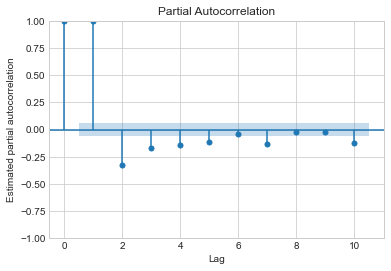

In [39]:
sm.graphics.tsa.plot_pacf(res.resid, lags=10)
plt.xlabel("Lag",fontsize = 10)
plt.ylabel("Estimated partial autocorrelation",fontsize = 10);
plt.show()

### Model selection 
- The theory states that in an autoregressive model its autocorrelation plot should depict an exponential decay and the number of lags pp should be taken from the partial autocorrelation chart using its pp most relevant lags. Applying the theory to our plots above, we conclude that our model is autoregressive of lag 1 also known as AR(1).

### ARIMA
In statistics ARIMA stands for autoregressive integrated moving average model and as can be inferred by the name AR models are as especial case of ARIMA therefore AR(1) is equivalent to ARIMA(1,0,0).

In [40]:
arima_results = ARIMA(df_combined["infections"], df_combined[["days","Face_Masks_Required_in_Public","policy_day"]], order=(1,0,0)).fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:             infections   No. Observations:                 1013
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1189.495
Date:                Thu, 03 Nov 2022   AIC                          -2366.989
Time:                        17:08:15   BIC                          -2337.465
Sample:                             0   HQIC                         -2355.775
                               - 1013                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.8396      0.587      1.430      0.153      -0.311       1.990
days                              0.0772      0.005     17.026      0.000 

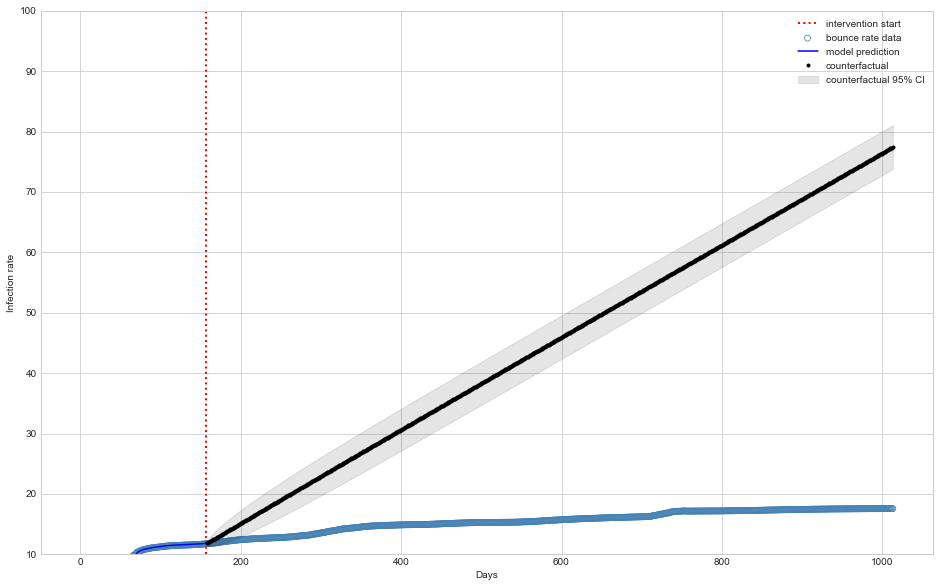

In [46]:
start = 157
end = 463

predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.05)

arima_cf = ARIMA(df_combined["infections"][:start], df_combined["days"][:start], order=(1,0,0)).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(856, exog=df_combined["days"][start:]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

#Plot line marking intervention moment
ax.axvline(x = 157, color = 'r', label = 'intervention start', linewidth=2,linestyle='dotted')



# Plot infection rate data
ax.scatter(df_combined["days"], df_combined["infections"], facecolors='none', edgecolors='steelblue', label="bounce rate data", linewidths=0.75)

# Plot model mean infection prediction

ax.plot(df_combined["days"][:start], y_pred[:start], 'b-', label="model prediction")
#ax.plot(df_combined["days"][start:], y_pred[start:], 'b-')

# Plot counterfactual mean infection rate with 95% confidence interval
ax.plot(df_combined["days"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_combined["days"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI");

ax.legend(loc='best')
plt.ylim([10, 100])
plt.xlabel("Days")
plt.ylabel("Infection rate");
